In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/measurements_10km_la.csv")

print(df.shape)

df.head()

(368614, 12)


,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm


In [30]:
# Split epoch into date and time columns
df['date'] = pd.to_datetime(df['epoch']).dt.date
df['time'] = pd.to_datetime(df['epoch']).dt.time

df.head()

,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units,date,time
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm,2016-11-15,20:00:00
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm,2016-11-16,00:00:00
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm,2016-11-16,01:00:00
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm,2016-11-16,02:00:00
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm,2016-11-16,03:00:00


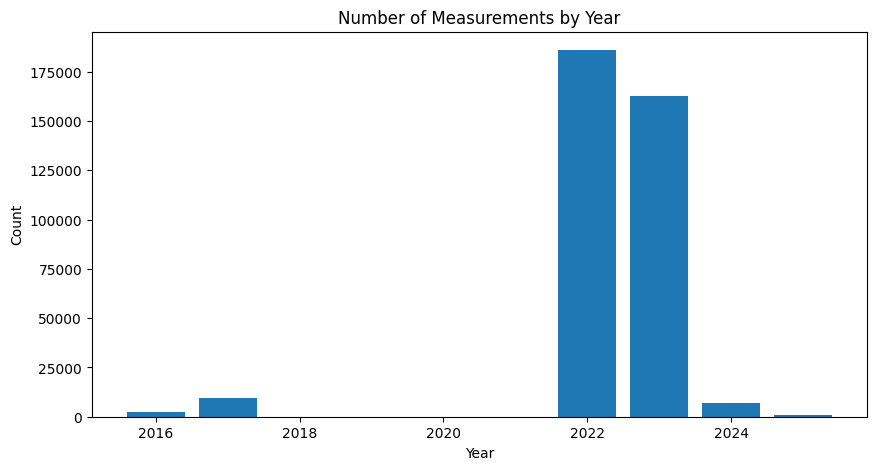

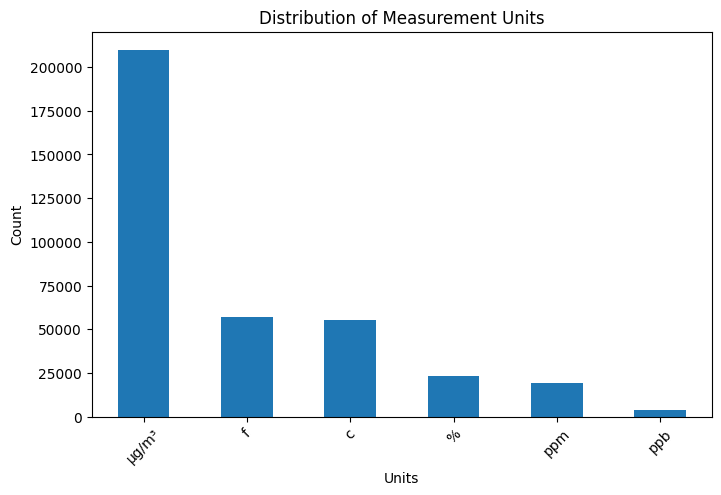

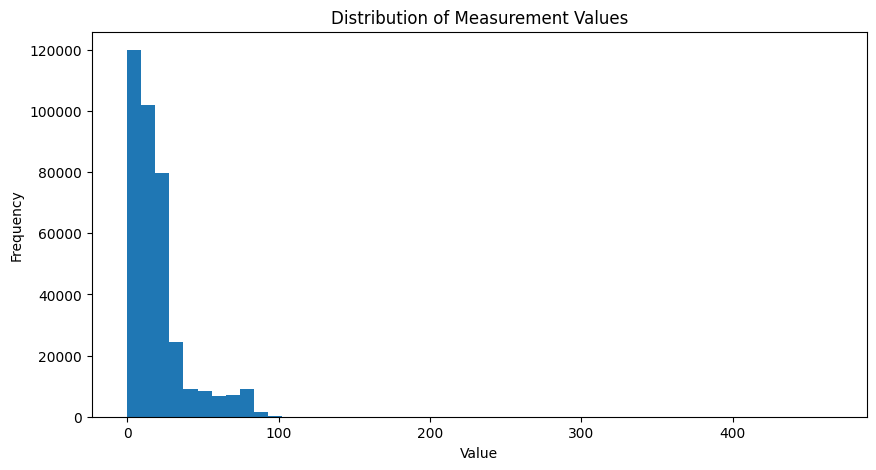

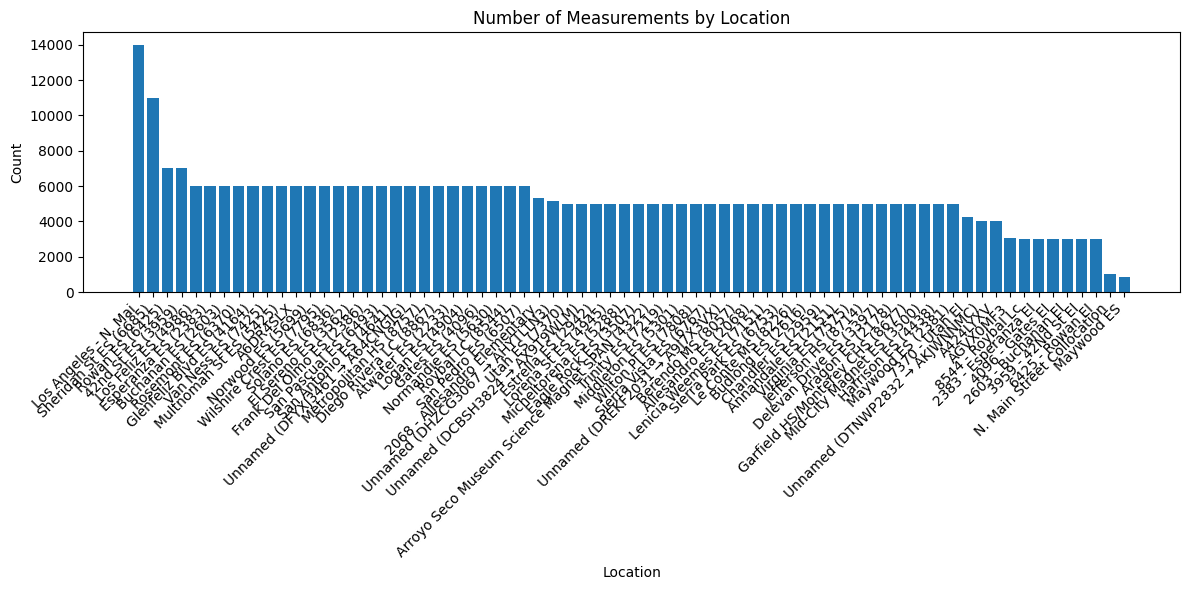

unique_id         0
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
date              0
time              0
year              0
dtype: int64

In [31]:
# Create year bucket from date
df['year'] = pd.to_datetime(df['date']).dt.year

# Count measurements per year
year_counts = df['year'].value_counts().sort_index()

# Plot measurements per year
plt.figure(figsize=(10,5))
plt.bar(year_counts.index, year_counts.values)
plt.title('Number of Measurements by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Plot histogram of units
plt.figure(figsize=(8,5))
df['units'].value_counts().plot(kind='bar')
plt.title('Distribution of Measurement Units')
plt.xlabel('Units')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot histogram of values
plt.figure(figsize=(10,5))
plt.hist(df['value'], bins=50)
plt.title('Distribution of Measurement Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Count measurements per location
location_counts = df['location'].value_counts()

# Plot measurements per location
plt.figure(figsize=(12,6))
plt.bar(range(len(location_counts)), location_counts.values)
plt.title('Number of Measurements by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(range(len(location_counts)), location_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()


df.isna().sum()


In [32]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.spatial import cKDTree
from geopy.distance import geodesic  # for an optional distance refinement
from tqdm import tqdm  # for a nice progress bar


def prepare_sensor_metadata(df):
    sensors_df = df[['sensor_id', 'latitude', 'longitude']].drop_duplicates(subset='sensor_id')
    sensors_df.reset_index(drop=True, inplace=True)
    return sensors_df


def build_sensor_tree(sensors_df):
    coords = sensors_df[['latitude', 'longitude']].to_numpy()
    tree = cKDTree(coords)
    return tree


def build_time_indexed_readings(df):
    # Ensure epoch is datetime
    df['epoch'] = pd.to_datetime(df['epoch'])

    # Group by sensor_id and sort each group by epoch
    time_dict = {}
    grouped = df.groupby('sensor_id', group_keys=False)
    for sid, group in grouped:
        group_sorted = group.sort_values('epoch')
        time_dict[sid] = group_sorted.reset_index(drop=True)
    return time_dict


def neighbors_within_distance(tree, sensors_df, lat, lon, max_distance_km):
    pass
    # Not working - need to redo this

def find_neighbor_reading_in_timewindow(sensor_id, target_time, time_indexed_dict, max_hours_ago):

    df_sensor = time_indexed_dict[sensor_id]  # all readings for that sensor, sorted by epoch
    start_time = target_time - timedelta(hours=max_hours_ago)

    mask = (df_sensor['epoch'] >= start_time) & (df_sensor['epoch'] <= target_time)
    window_data = df_sensor[mask]
    if window_data.empty:
        return None

    latest_row = window_data.iloc[window_data['epoch'].argmax()]

    reading_value = latest_row['value']
    delta = target_time - latest_row['epoch']
    time_elapsed = delta.total_seconds() / 3600.0  # in hours

    return reading_value, time_elapsed


def build_training_dataset(
    df, max_distance_km=5, max_hours_ago=6, k_neighbors=3,
    verbose=True
):

    df['epoch'] = pd.to_datetime(df['epoch'])

    if verbose: print("Preparing sensor metadata...")
    sensors_df = prepare_sensor_metadata(df)

    if verbose: print("Building KD-tree...")
    tree = build_sensor_tree(sensors_df)

    if verbose: print("Indexing sensor time-series...")
    time_indexed_dict = build_time_indexed_readings(df)

    results = []

    if verbose: print("Building training dataset...")

    # We'll do a simple progress bar with tqdm
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        target_sensor = row['sensor_id']
        target_lat = row['latitude']
        target_lon = row['longitude']
        target_time = row['epoch']
        target_value = row['value']
        neighbors = neighbors_within_distance(tree, sensors_df, target_lat, target_lon, max_distance_km)

        neighbor_features = []
        for sid, dist_km in neighbors:
            if sid == target_sensor:
                continue

            nr = find_neighbor_reading_in_timewindow(sid, target_time, time_indexed_dict, max_hours_ago)
            if nr is not None:
                reading_val, time_elapsed = nr
                neighbor_features.append((dist_km, reading_val, time_elapsed))

            if len(neighbor_features) >= k_neighbors:
                break

        if len(neighbor_features) < k_neighbors:
            continue

        row_dict = {
            'target_sensor_id': target_sensor,
            'target_location_id': row.get('location_id', None),
            'target_time': target_time,
            'target_value': target_value
        }
        for i in range(k_neighbors):
            dist_km, nval, telapsed = neighbor_features[i]
            row_dict[f'neighbor{i+1}_distance'] = dist_km
            row_dict[f'neighbor{i+1}_reading'] = nval
            row_dict[f'neighbor{i+1}_time_elapsed'] = telapsed

        results.append(row_dict)

    train_df = pd.DataFrame(results)
    if verbose:
        print(f"Final training dataset size: {train_df.shape}")
    return train_df

train_df = build_training_dataset(df, max_distance_km=5, max_hours_ago=6, k_neighbors=3)
train_df.head()


Preparing sensor metadata...
Building KD-tree...
Indexing sensor time-series...
Building training dataset...


Processing rows:   0%|          | 644/368614 [00:32<5:05:38, 20.07it/s]


KeyboardInterrupt: 